In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import random
import seaborn as sns

def load_data(directory, img_size, num_classes=60):
    all_arrays = []
    classes = []
    for i in os.listdir(directory):
        path = os.path.join(directory, i)
        if os.path.isdir(path):
            if num_classes is not None and len(classes) >= num_classes:
                break
            classes.append(i)
            class_num = classes.index(i)
            for img in os.listdir(path):
                try:
                    img_array = cv2.imread(os.path.join(path, img))
                    img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
                    all_arrays.append([img_array, class_num])
                except Exception as e:
                    print(f"Error processing image: {img}, {e}")
    return all_arrays, classes


img_size = 100

train_directory = "../input/fruits-360_dataset/fruits-360/Training"
train_all_arrays, classes = load_data(train_directory, img_size)

test_directory = "../input/fruits-360_dataset/fruits-360/Test"
test_all_arrays, _ = load_data(test_directory, img_size)  




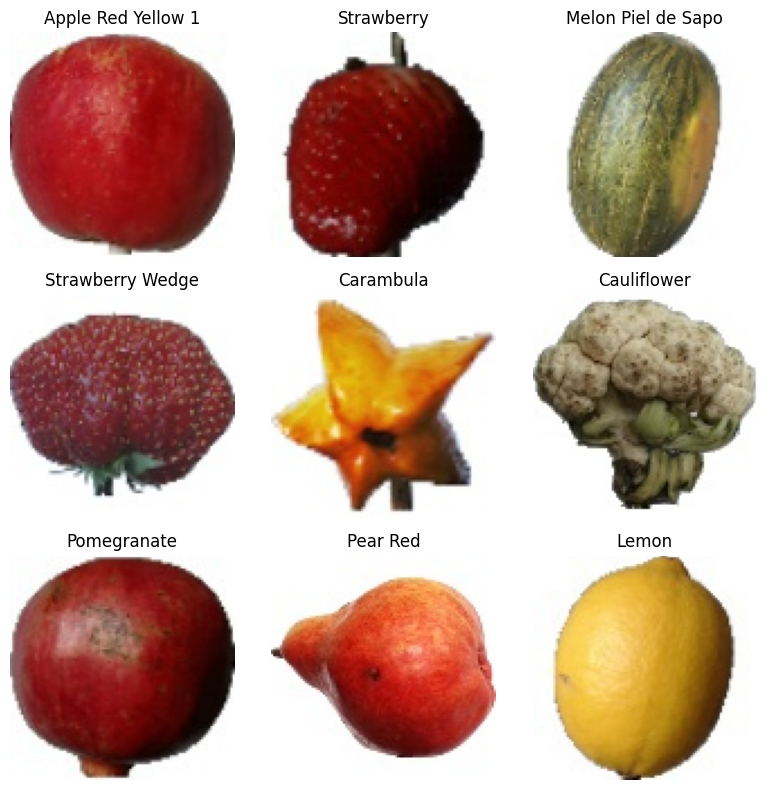

In [2]:
def display_images_by_class(data, classes, num_rows, num_cols):
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(8, 8))
    axes = axes.flatten()

    # Select 9 random classes
    selected_classes = random.sample(classes, 9)
    
    # Select a random image from each class
    class_indices = {c: [] for c in selected_classes}
    for i, (img, label) in enumerate(data):
        if classes[label] in selected_classes:
            class_indices[classes[label]].append(i)

    for i, class_name in enumerate(selected_classes):
        # Select a random image from the class
        img_index = np.random.choice(class_indices[class_name])
        img, label = data[img_index]
        axes[i].imshow(img)
        axes[i].set_title(class_name)
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

display_images_by_class(train_all_arrays, classes, 3, 3)

In [3]:
# Shuffle the training data
np.random.shuffle(train_all_arrays)

# Create training data arrays
X_train = np.array([features for features, label in train_all_arrays])
Y_train = np.array([label for features, label in train_all_arrays])

# Shuffle the test data
np.random.shuffle(test_all_arrays)

# Create test data arrays
X_test = np.array([features for features, label in test_all_arrays])
Y_test = np.array([label for features, label in test_all_arrays])


In [4]:
#normalization and reshaping
X_train=X_train.reshape(-1,img_size,img_size,3)
X_train=X_train / 255
X_test=X_test.reshape(-1,img_size,img_size,3)
X_test=X_test / 255


In [5]:
from keras.utils import to_categorical
Y_train=to_categorical(Y_train,num_classes=len(classes))
Y_test=to_categorical(Y_test,num_classes=len(classes))


In [6]:
from sklearn.model_selection import train_test_split
x_train,x_val,y_train,y_val=train_test_split(X_train,Y_train,test_size=0.2,random_state=50)

In [7]:
# Defining the model 
# The model is using 3 layer convolution neural network with 8, 32 and 128 filters
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau

model = Sequential()
model.add(Conv2D(filters=8, kernel_size=(3, 3), padding="Same", activation="relu", input_shape=(100, 100, 3)))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.35))

model.add(Conv2D(filters=32, kernel_size=(3, 3), padding="Same", activation="relu"))
model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.35))

model.add(Conv2D(filters=128, kernel_size=(3, 3), padding="Same", activation="relu"))
model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.35))
model.add(Flatten())
model.add(Dense(512, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(len(classes), activation="softmax"))

# Defining optimizer
optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

# Compile the model
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])



/Users/resyurika/Desktop/env/AIMV/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [8]:
# Data augmentation

datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=False,
    vertical_flip=False
)

datagen.fit(X_train)


In [9]:
epochs = 10
batch_size = 32
# Model fitting using `fit` method
history = model.fit(
    datagen.flow(X_train, Y_train, batch_size=batch_size),
    epochs=epochs,
    
    validation_data=(x_val, y_val),
    steps_per_epoch=x_train.shape[0] // batch_size
)

Epoch 1/10


/Users/resyurika/Desktop/env/AIMV/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


787/787 ━━━━━━━━━━━━━━━━━━━━ 62s 78ms/step - accuracy: 0.2765 - loss: 2.7516 - val_accuracy: 0.9302 - val_loss: 0.2684
Epoch 2/10
198/787 ━━━━━━━━━━━━━━━━━━━━ 39s 68ms/step - accuracy: 0.8261 - loss: 0.5212

2024-08-22 03:49:31.844086: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/opt/homebrew/Cellar/python@3.12/3.12.5/Frameworks/Python.framework/Versions/3.12/lib/python3.12/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


787/787 ━━━━━━━━━━━━━━━━━━━━ 17s 21ms/step - accuracy: 0.8270 - loss: 0.5124 - val_accuracy: 0.9483 - val_loss: 0.1850
Epoch 3/10
787/787 ━━━━━━━━━━━━━━━━━━━━ 55s 69ms/step - accuracy: 0.8634 - loss: 0.3989 - val_accuracy: 0.9495 - val_loss: 0.1259
Epoch 4/10
198/787 ━━━━━━━━━━━━━━━━━━━━ 38s 65ms/step - accuracy: 0.9224 - loss: 0.2378

2024-08-22 03:50:42.993910: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


787/787 ━━━━━━━━━━━━━━━━━━━━ 16s 20ms/step - accuracy: 0.9195 - loss: 0.2380 - val_accuracy: 0.9586 - val_loss: 0.1134
Epoch 5/10
787/787 ━━━━━━━━━━━━━━━━━━━━ 56s 70ms/step - accuracy: 0.9250 - loss: 0.2167 - val_accuracy: 0.9944 - val_loss: 0.0346
Epoch 6/10
787/787 ━━━━━━━━━━━━━━━━━━━━ 16s 21ms/step - accuracy: 0.9397 - loss: 0.1673 - val_accuracy: 0.9632 - val_loss: 0.0948
Epoch 7/10
787/787 ━━━━━━━━━━━━━━━━━━━━ 55s 69ms/step - accuracy: 0.9472 - loss: 0.1550 - val_accuracy: 0.9868 - val_loss: 0.0377
Epoch 8/10
198/787 ━━━━━━━━━━━━━━━━━━━━ 38s 65ms/step - accuracy: 0.9556 - loss: 0.1285

2024-08-22 03:53:05.639960: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


787/787 ━━━━━━━━━━━━━━━━━━━━ 16s 20ms/step - accuracy: 0.9568 - loss: 0.1256 - val_accuracy: 0.9659 - val_loss: 0.0972
Epoch 9/10
787/787 ━━━━━━━━━━━━━━━━━━━━ 56s 70ms/step - accuracy: 0.9533 - loss: 0.1354 - val_accuracy: 0.9770 - val_loss: 0.0590
Epoch 10/10
787/787 ━━━━━━━━━━━━━━━━━━━━ 16s 20ms/step - accuracy: 0.9601 - loss: 0.1122 - val_accuracy: 0.9779 - val_loss: 0.0572


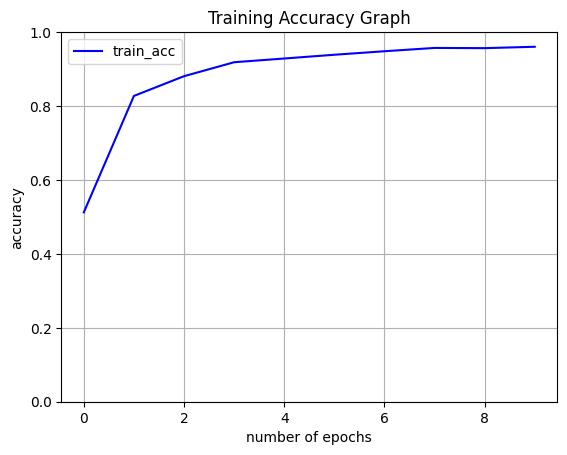

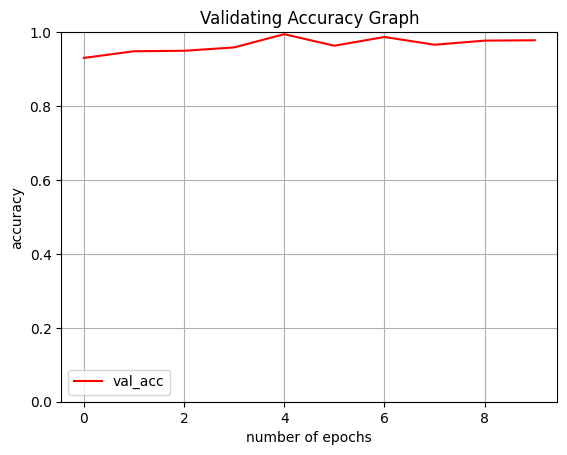

In [10]:
# model evaluation plot trainning_accuracy-epoches relativity graph
plt.plot(history.history["accuracy"],color="b",label="train_acc")
plt.title("Training Accuracy Graph")
plt.xlabel("number of epochs")
plt.ylabel("accuracy")
plt.legend()
plt.grid()
plt.ylim(0, 1)
plt.show()


# Model evaluation: Plot validate_accuracy-epoches relativity graph 
plt.plot(history.history["val_accuracy"],color="r",label="val_acc")
plt.title("Validating Accuracy Graph")
plt.xlabel("number of epochs")
plt.ylabel("accuracy")
plt.legend()
plt.grid()
plt.ylim(0, 1)
plt.show()



197/197 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step


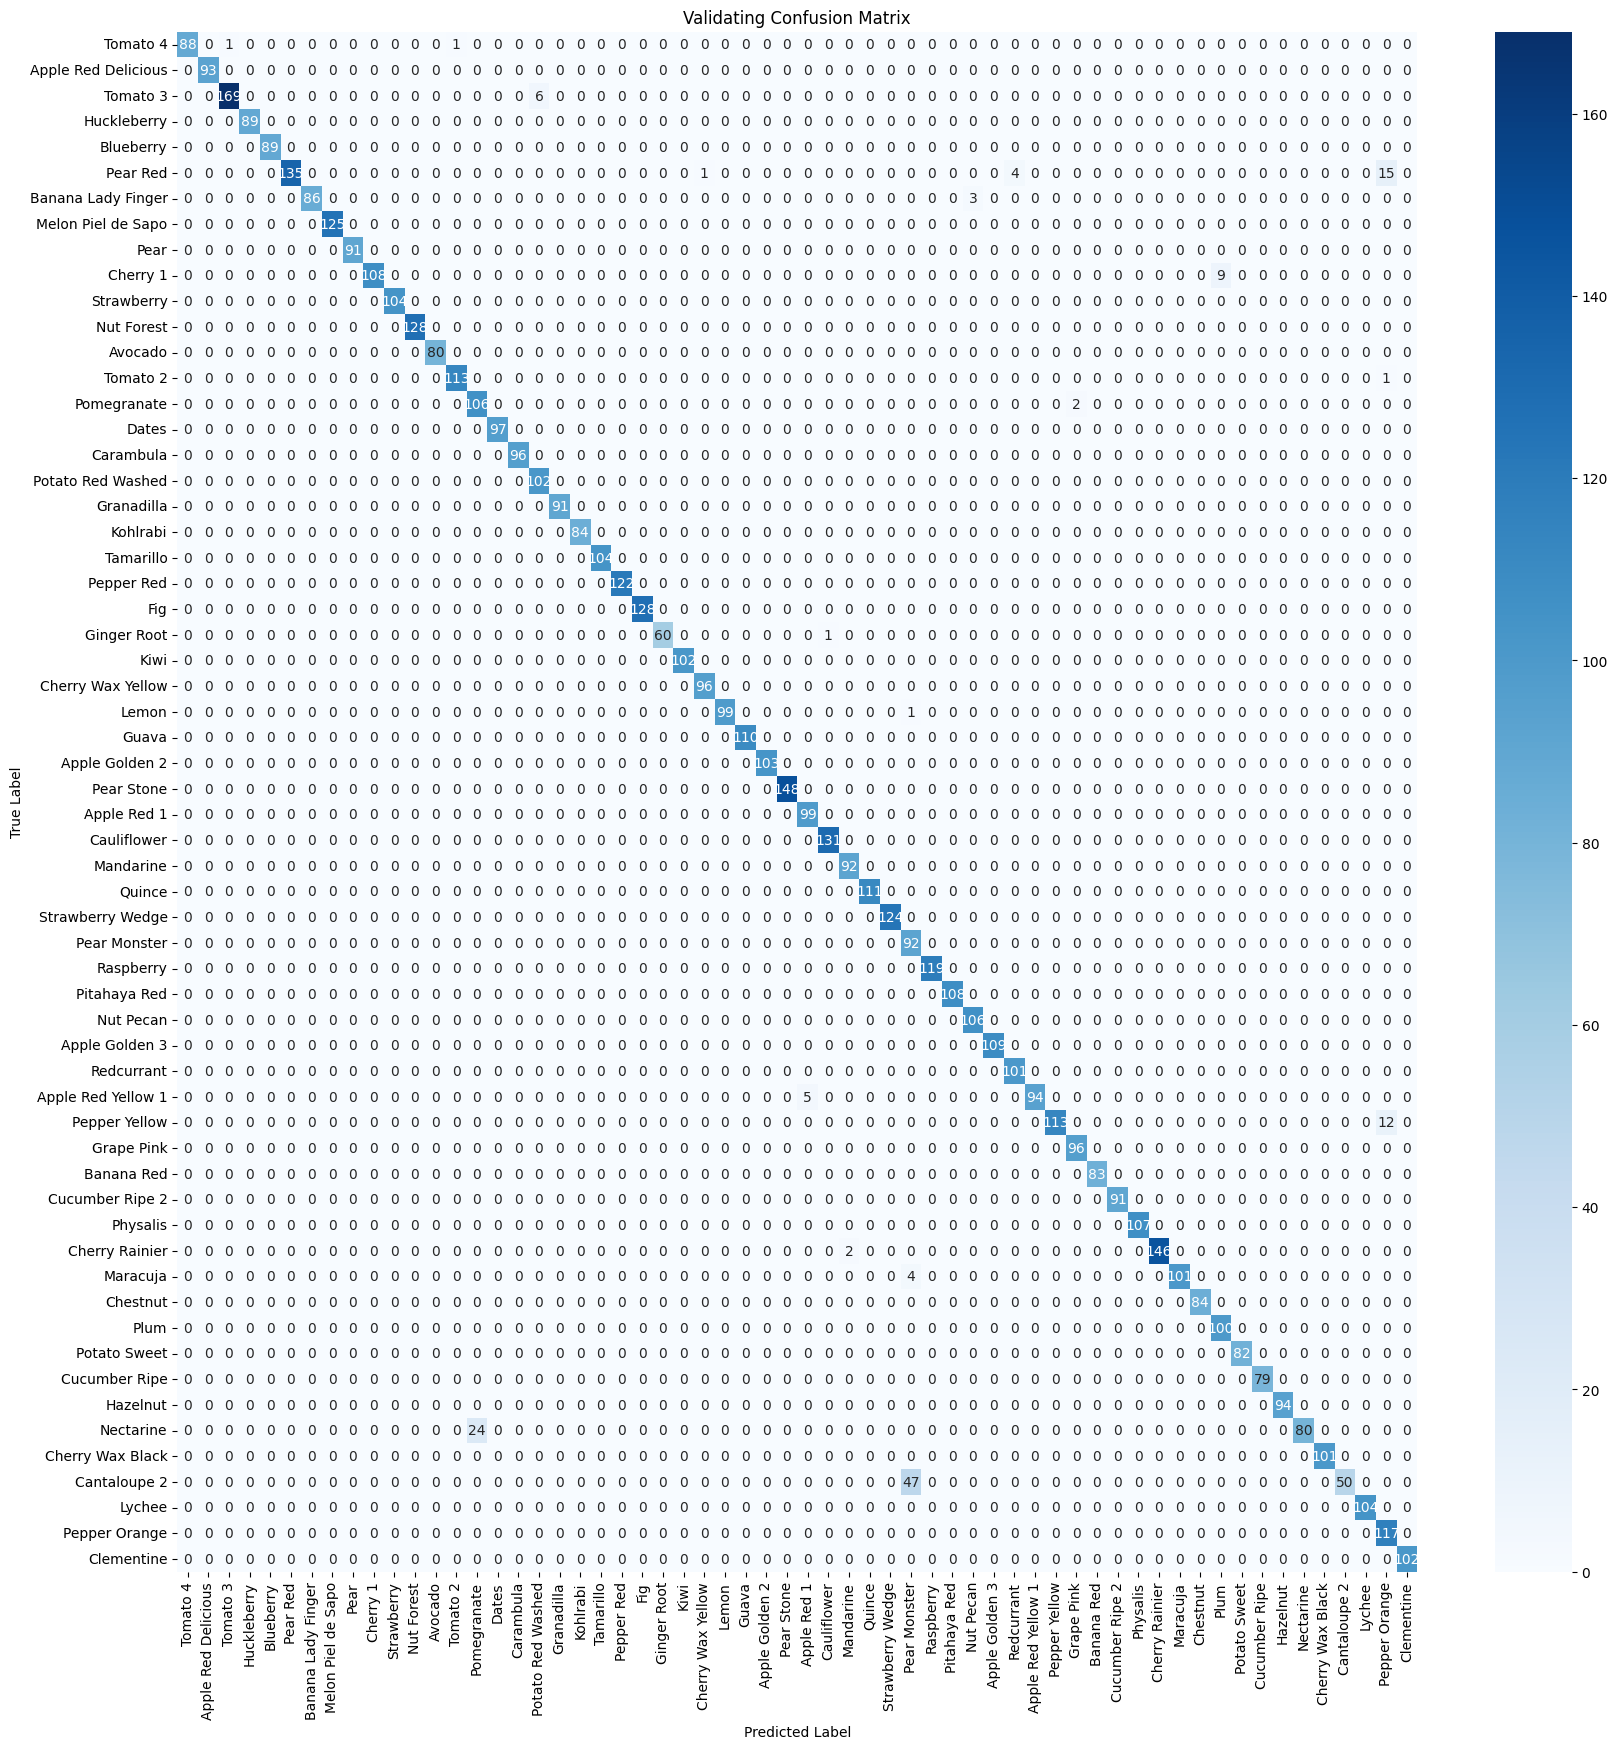

In [11]:

# Model evaluation: confusion matrix
from sklearn.metrics import confusion_matrix
# Plot validating confusion matrix
y_pred=model.predict(x_val)
y_pred_classes=np.argmax(y_pred,axis=1)
y_true=np.argmax(y_val,axis=1)
conf_mat=confusion_matrix(y_true,y_pred_classes)
plt.figure(figsize=(20,20))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Validating Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()




330/330 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step


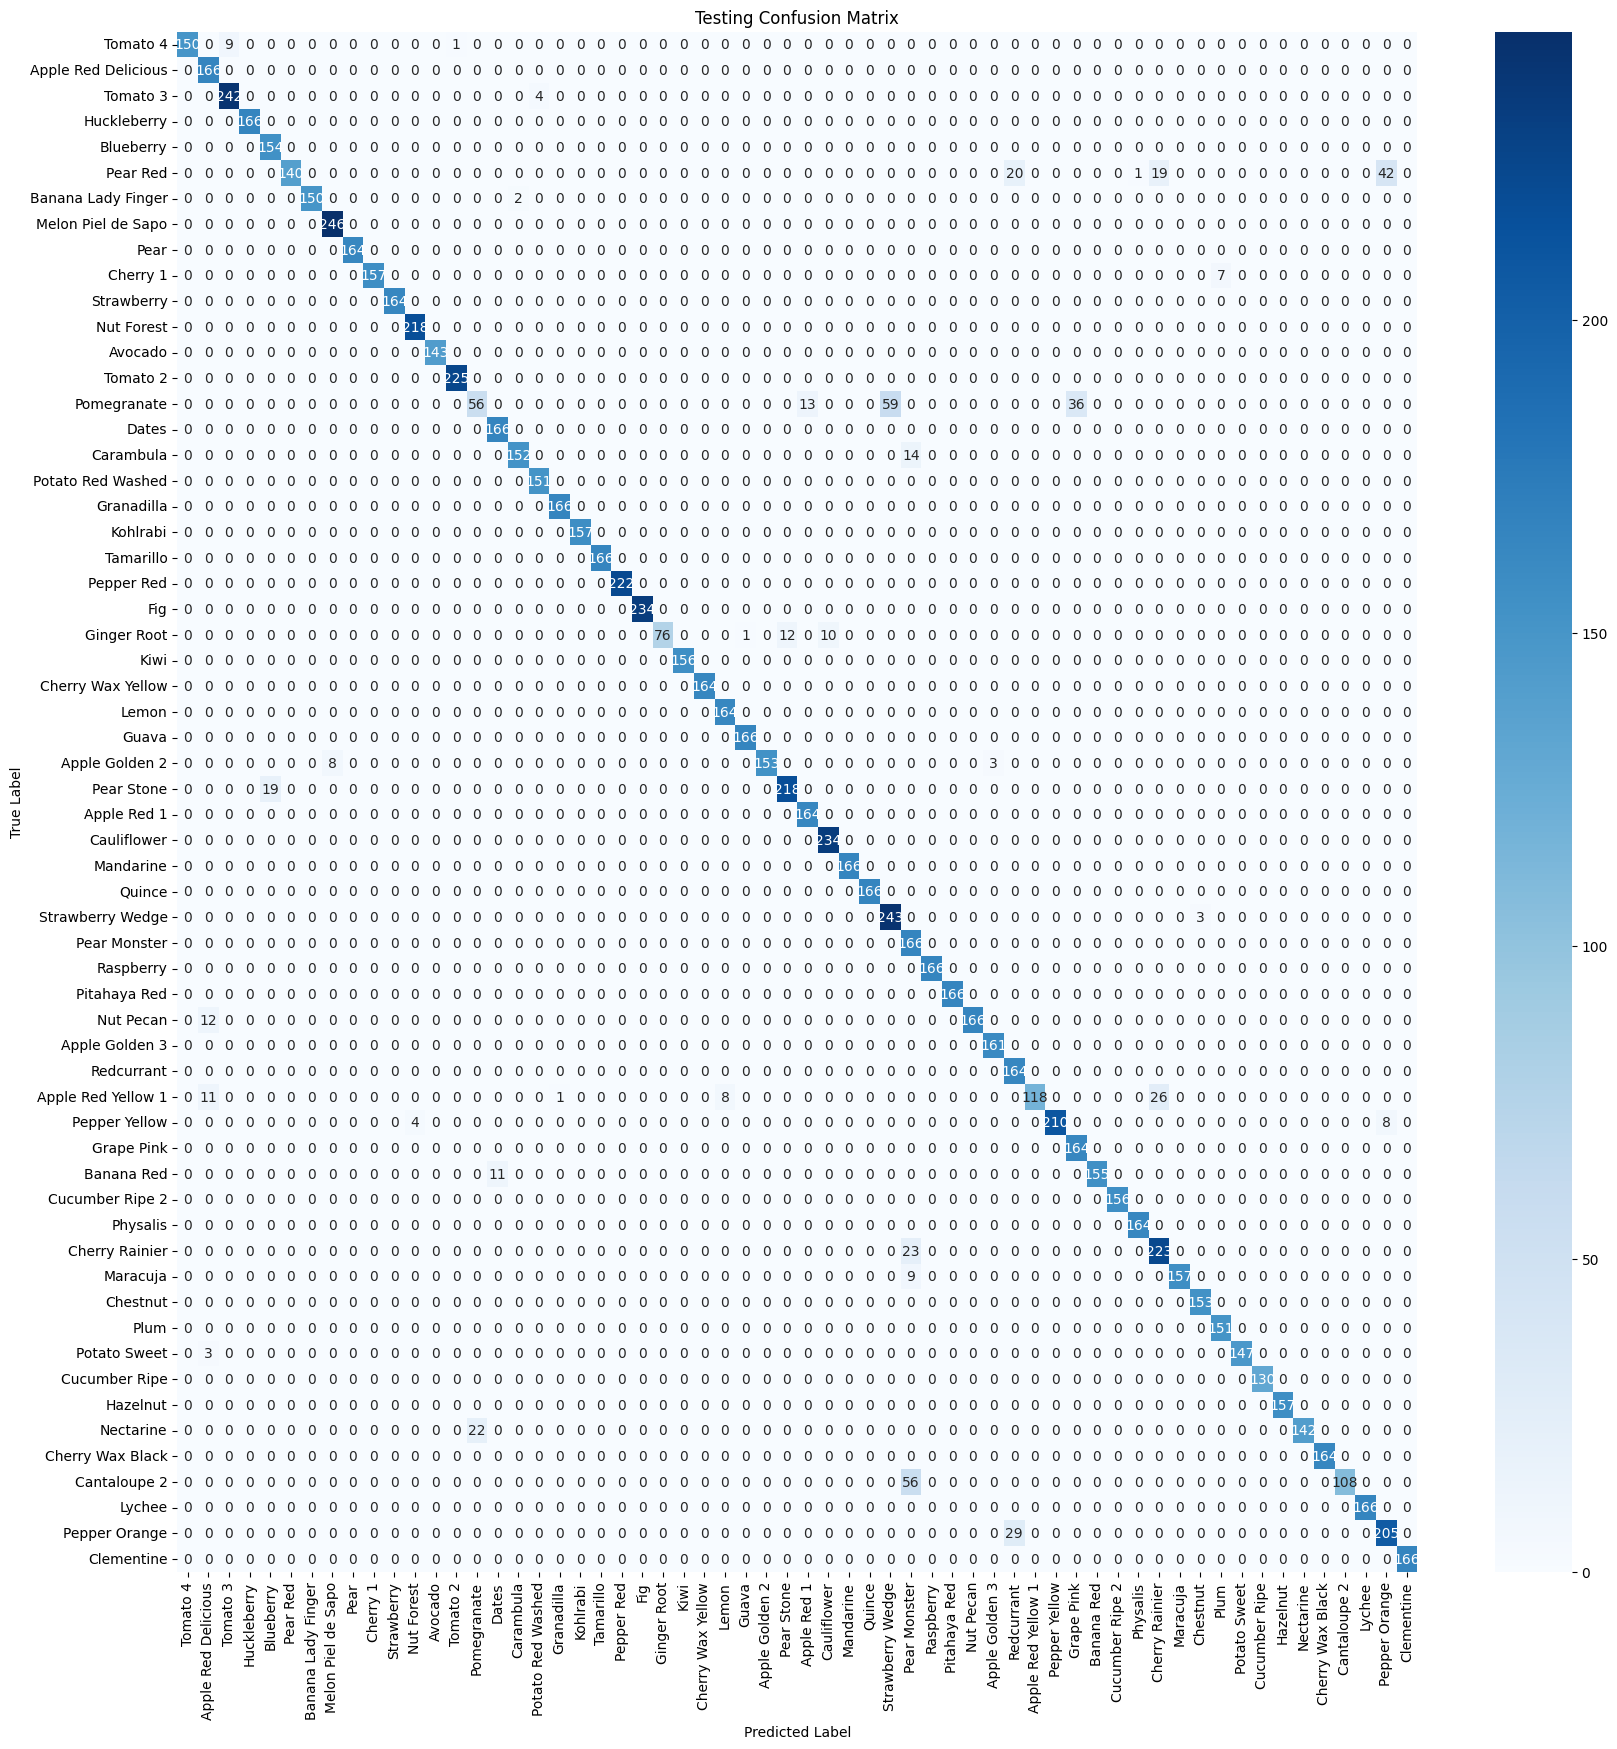

In [12]:
# Plot Testing confusion matrix
y_pred2=model.predict(X_test)
y_pred_classes2=np.argmax(y_pred2,axis=1)
y_true2=np.argmax(Y_test,axis=1)
#compute conf mat
conf_mat2=confusion_matrix(y_true2,y_pred_classes2)
plt.figure(figsize=(20,20))
sns.heatmap(conf_mat2, annot=True, fmt="d", cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Testing Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()



In [13]:
results = model.evaluate(X_test, Y_test, batch_size=64)

165/165 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.9493 - loss: 0.1460


In [14]:
test_loss, test_acc = model.evaluate(X_test, Y_test, verbose=2)
print('\nTest accuracy:', test_acc)


330/330 - 5s - 16ms/step - accuracy: 0.9521 - loss: 0.1438

Test accuracy: 0.9520651698112488


In [15]:
model.save("model.h5")

In [16]:
import tensorflow as tf
import keras
model = tf.keras.models.load_model("model.h5")